# Solutions Task 4
Author: Luis Denninger 

## Imports

In [1]:
import os
from functools import reduce
from pathlib import Path as P

import numpy as np

import torch
import torch.nn 
import torch.nn.functional as fun
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

import torchvision as tv

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import matplotlib.patches as patches
import seaborn as sn
from sklearn.metrics import confusion_matrix

import yaml

import copy

from tqdm import tqdm

import optuna

import pandas as pd

import plotly

from fvcore.nn import FlopCountAnalysis, flop_count_str, ActivationCountAnalysis

import ipdb

import inspect

import torchgadgets as tg

## Data

In [2]:
tg.tools.set_random_seed(42)

data = tg.data.load_dataset('oxfordpet')


train_dataset = data['train_dataset']
test_dataset = data['test_dataset']

dog_inds = [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21,22, 24, 25, 28, 29, 30, 31, 34, 35, 36]
cat_inds = [0, 5, 6, 7, 8, 11, 20, 23, 26, 27, 32, 33]

category_names = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle',
    'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau',
    'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees',
    'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher',
    'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard',
    'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier',
    'wheaten_terrier', 'yorkshire_terrier'
]



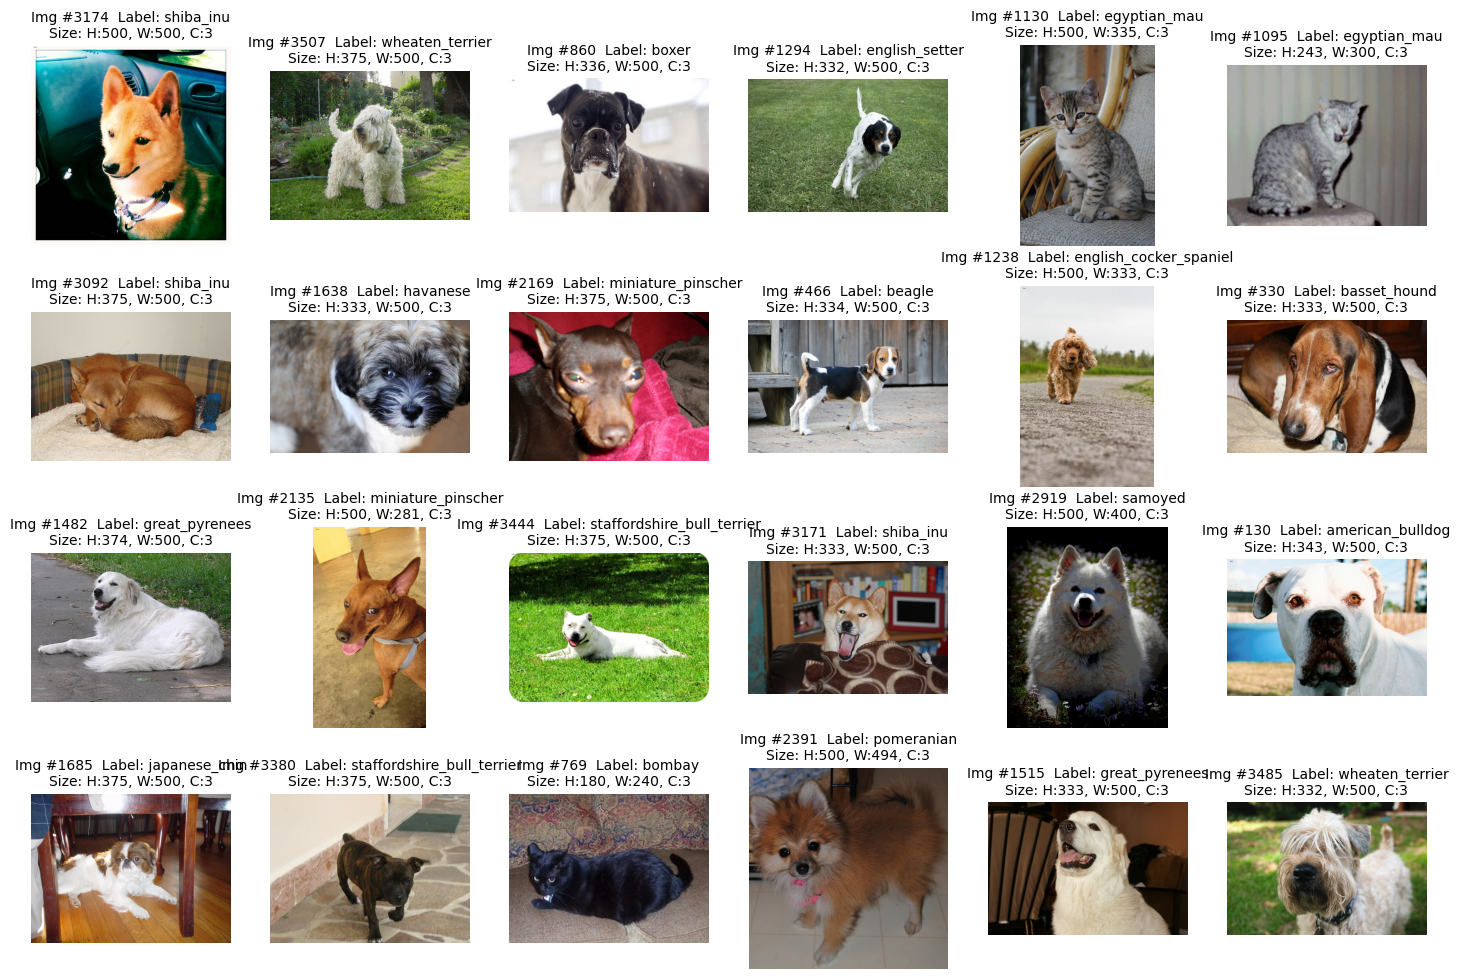

In [3]:
tg.visualization.visualize_dataset(test_dataset, label_names=category_names, layout=(4,6))

In [4]:
class_inds = {}
for i, (img, label) in enumerate(train_dataset):

    class_inds[label] = i

class_idns = [v for k,v in class_inds.items()]



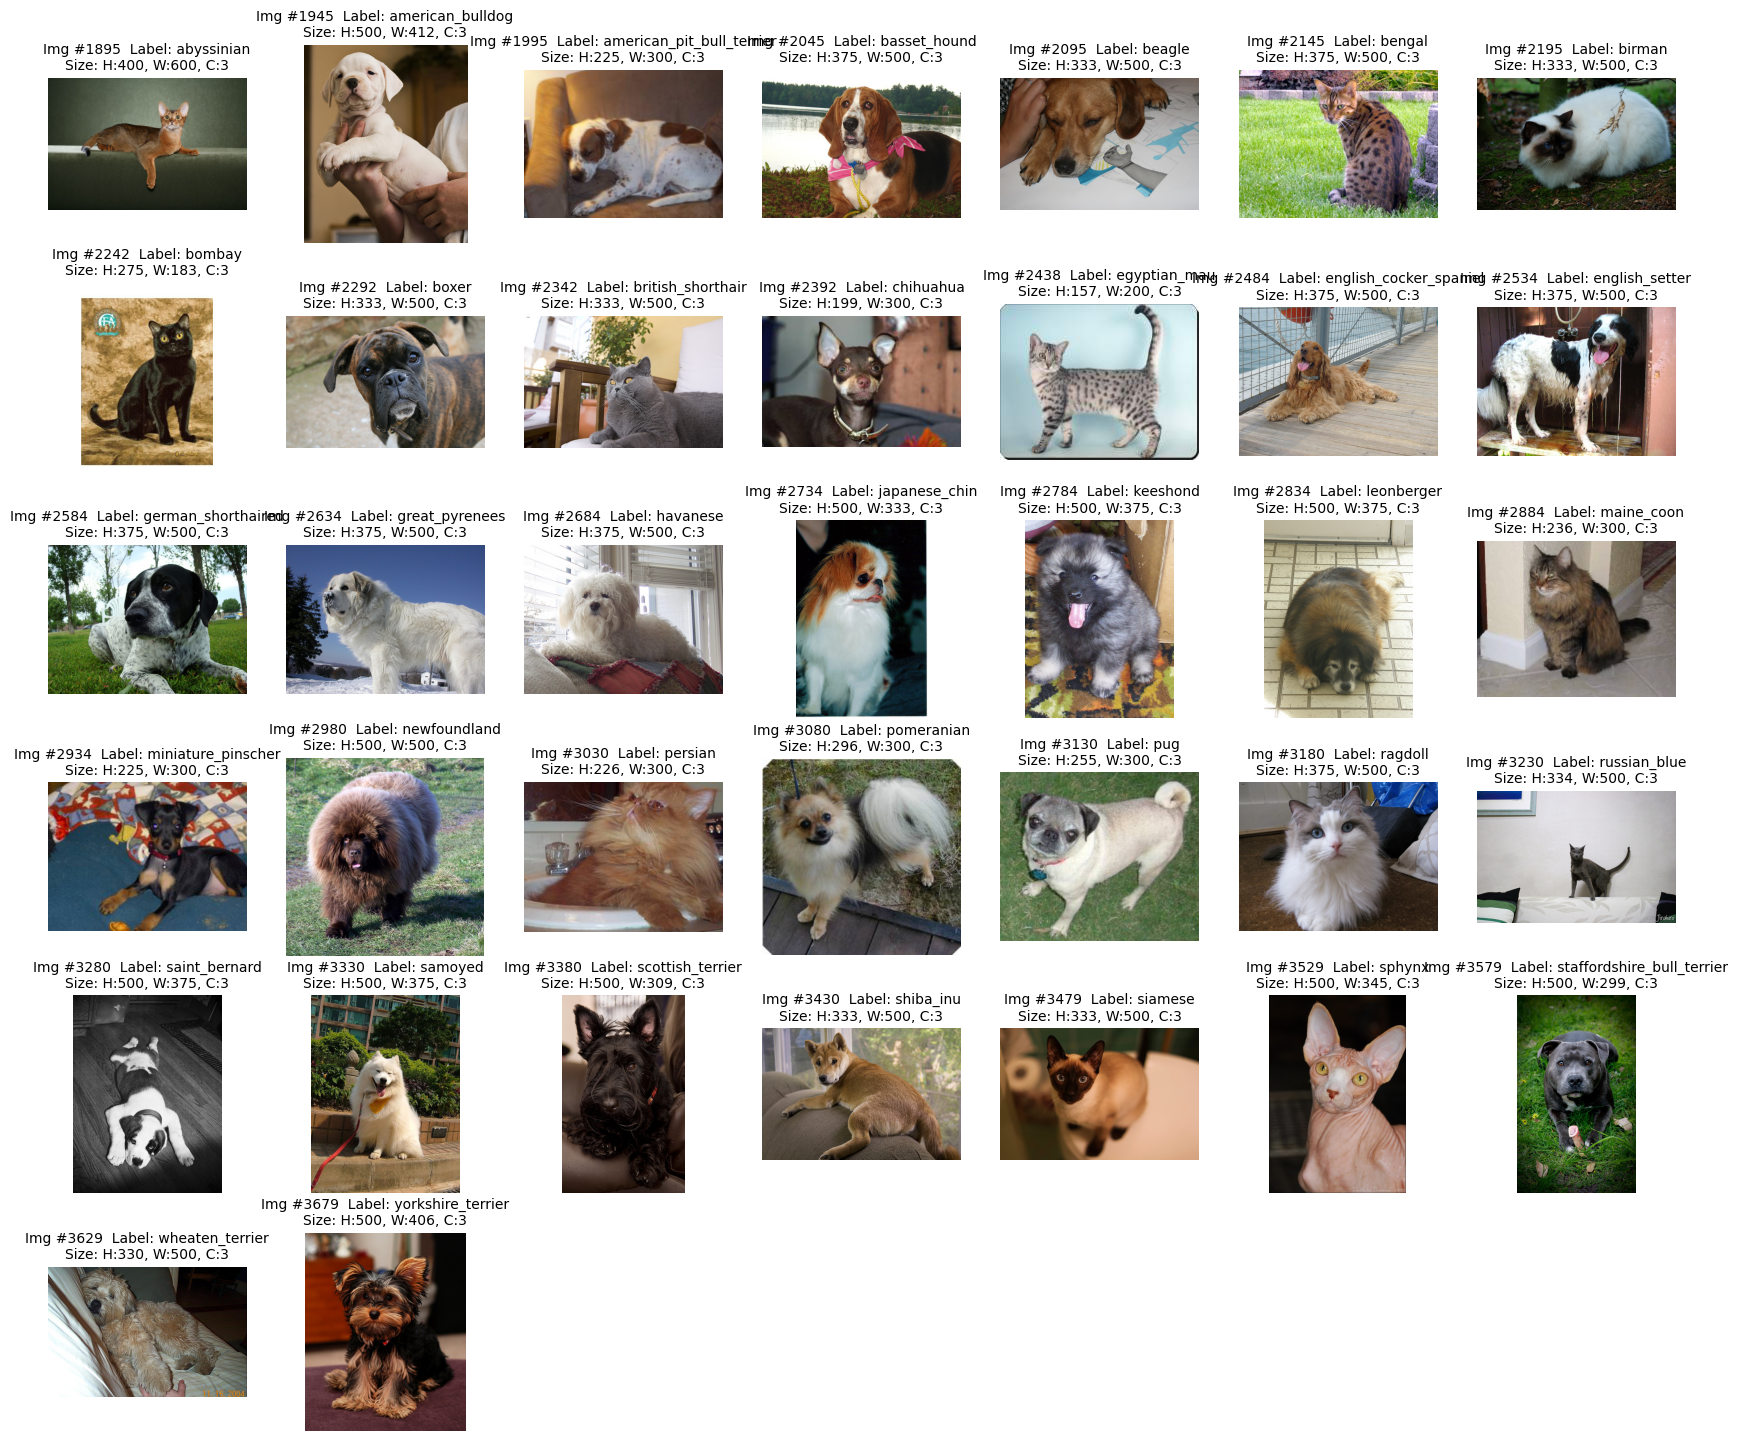

In [5]:


tg.visualization.visualize_dataset(train_dataset, ind=class_idns, label_names=category_names, layout=(6,7))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


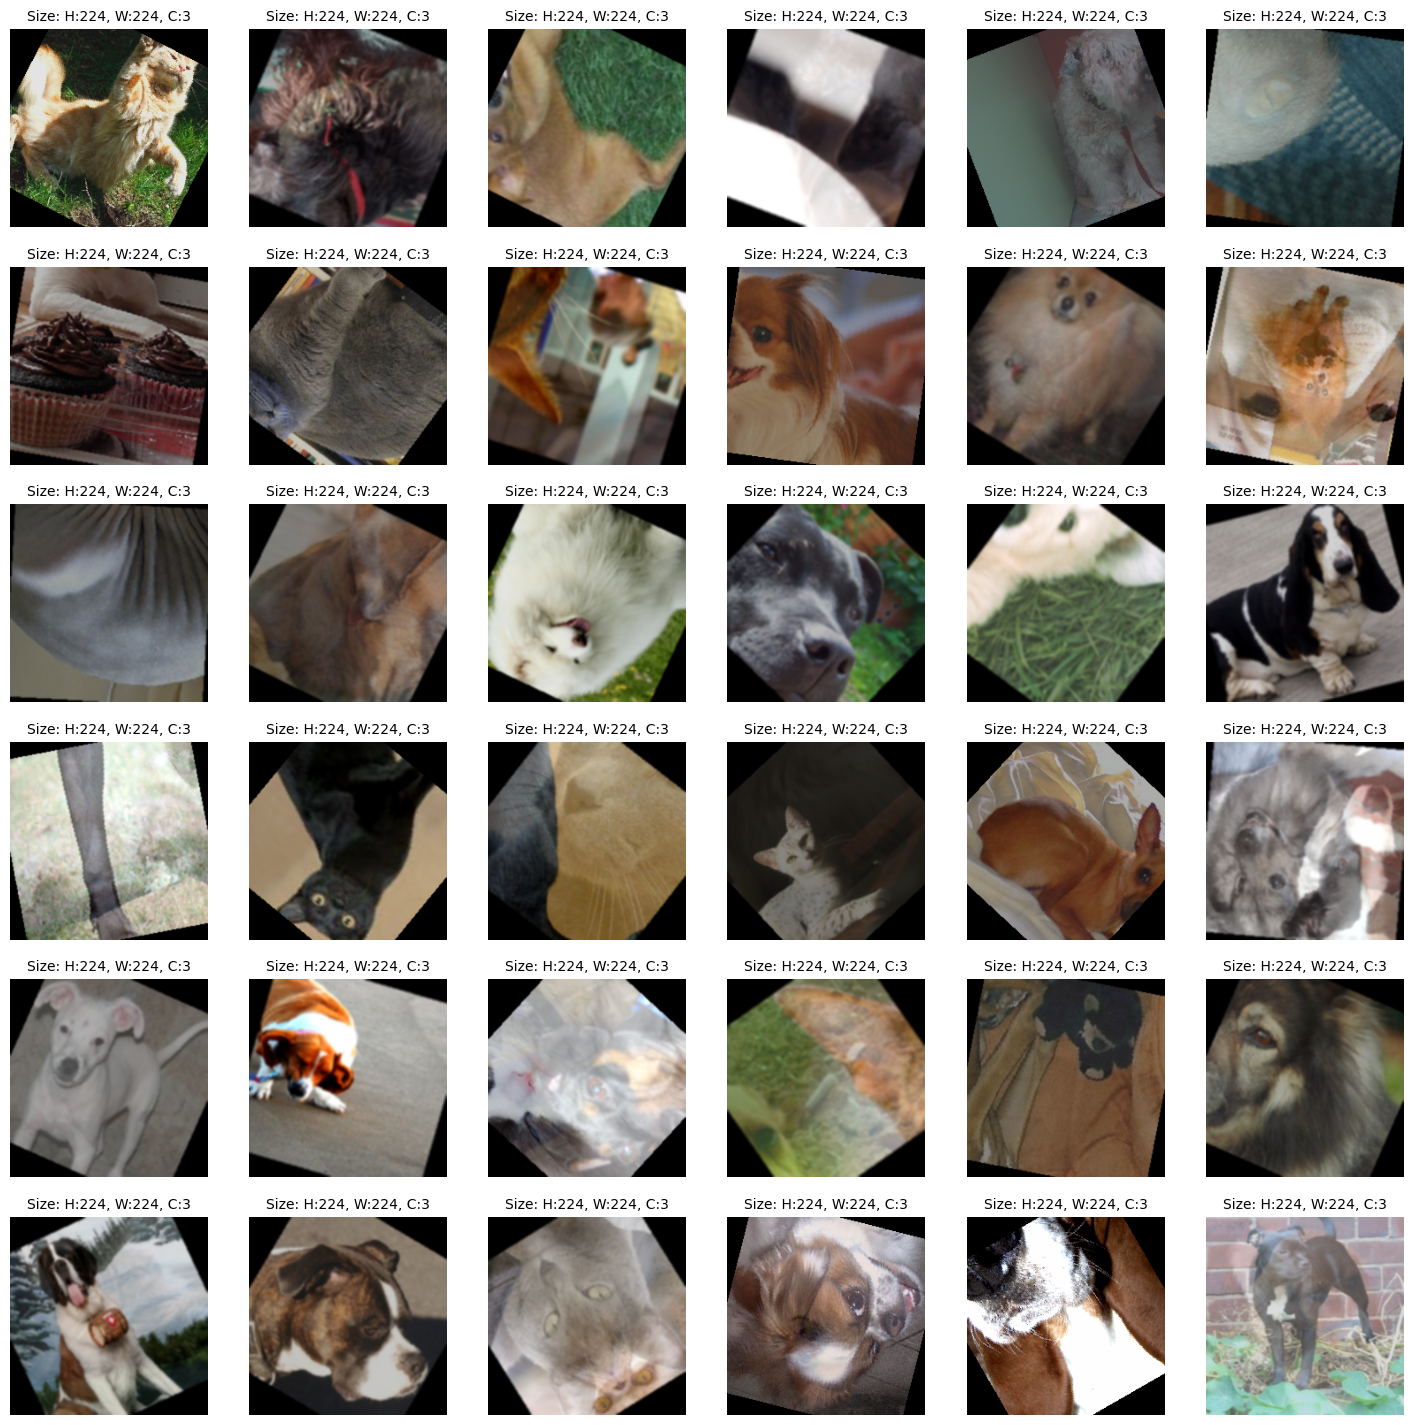

In [6]:
augm_config = [
            {
                "type": "mixup",
                "alpha": 1.0,
                "prob": 0.5,
                "beta": 1.0,
                "num_classes": 37,
                "train": True,
                "eval": False
            },
            {
                "type": "color_jitter",
                "brightness": 0.4,
                "contrast": 0.4,
                "saturation": 0.3,
                "hue": 0.0,
                "train": True,
                "eval": False
            },
            {
                "type": "random_horizontal_flip",
                "prob": 0.3,
                "train": True,
                "eval": False
            },
            {
                "type": "random_vertical_flip",
                "prob": 0.5,
                "train": True,
                "eval": False
            },
            {
                "type": "random_rotation",
                "degrees": 45,
                "train": True,
                "eval": False
            },
            {
                "type": "gaussian_blur",
                "kernel_size": [
                    5,
                    5
                ],
                "sigma": [
                    0.1,
                    2.0
                ],
                "train": True,
                "eval": False
            },
        ]

load_conf = [
    {
        "type": "toTensor",
        "train": True,
        "eval": False
    },
    {
        "type": "random_resized_crop",
        "size": [
            224,
            224
        ],
        "scale": [
            0.08,
            1.0
        ],
        "ratio": [
            0.75,
            1.3333
        ],
        "train": True,
        "eval": False
    }
]

ds = tg.data.ImageDataset(train_dataset, load_conf)

data_augmentor = tg.data.ImageDataAugmentor(config = augm_config)

tg.visualization.visualize_dataloader(ds, data_augmentor, category_names, layout=(6,6))




## Model Experiments


## Data Augmentation Ablation Studies

## Training Parameters

In [7]:
exp_name = 'convnext_large'
run_name = 'opt_study'
study_name = 'opt_study'

study_dir = os.path.join(os.getcwd(), 'experiments', exp_name, run_name)

log_dir = 'sqlite:///' + os.path.join(os.getcwd(),'experiments', exp_name, run_name, 'logs', study_name+'.db')

study = optuna.create_study(study_name=study_name,
                                storage=log_dir, load_if_exists=True,
                                    direction='maximize',
                                        sampler = optuna.samplers.TPESampler(), 
                                            pruner = optuna.pruners.MedianPruner(n_warmup_steps=5))

[I 2023-05-16 20:09:07,302] Using an existing study with name 'opt_study' instead of creating a new one.


In [10]:
fig = optuna.visualization.plot_contour(study, params=['learning_rate', 'decay_factor'], target_name='Accuracy')
fig.show()


In [11]:
fig = optuna.visualization.plot_contour(study, params=['learning_rate', 'batch_size'], target_name='Accuracy')
fig.show()

In [12]:
fig = optuna.visualization.plot_slice(study, params=['learning_rate', 'batch_size', 'decay_factor'], target_name='Accuracy')
fig.show()